In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
run_name = "12_16_19_run_01"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [6]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [7]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [8]:
from pore_utils import raw_signal_utils
from pore_utils import smith_waterman as s_w

In [9]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [10]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [11]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[12:22:38 - __main__] Getting molbit sequences.
[12:22:38 - __main__] Locating fastq files.
[12:22:38 - __main__] Running SW, one fastq at a time.
[12:22:38 - __main__] Starting fastq (0 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_0.fastq


[########################################] | 100% Completed | 26.7s


[12:23:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_0.tsv
[12:23:05 - __main__] Starting fastq (1 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_1.fastq


[########################################] | 100% Completed | 42.9s


[12:23:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_1.tsv
[12:23:49 - __main__] Starting fastq (2 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_2.fastq


[########################################] | 100% Completed | 44.7s


[12:24:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_2.tsv
[12:24:34 - __main__] Starting fastq (3 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_3.fastq


[########################################] | 100% Completed | 28.7s


[12:25:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_0_3.tsv
[12:25:03 - __main__] Starting fastq (4 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_0.fastq


[########################################] | 100% Completed | 43.2s


[12:25:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_0.tsv
[12:25:47 - __main__] Starting fastq (5 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_1.fastq


[########################################] | 100% Completed | 37.7s


[12:26:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_1.tsv
[12:26:25 - __main__] Starting fastq (6 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_2.fastq


[########################################] | 100% Completed | 43.9s


[12:27:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_2.tsv
[12:27:09 - __main__] Starting fastq (7 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_3.fastq


[########################################] | 100% Completed | 21.8s


[12:27:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_1_3.tsv
[12:27:31 - __main__] Starting fastq (8 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_0.fastq


[########################################] | 100% Completed | 54.5s


[12:28:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_0.tsv
[12:28:26 - __main__] Starting fastq (9 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_1.fastq


[########################################] | 100% Completed |  1min 16.7s


[12:29:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_1.tsv
[12:29:43 - __main__] Starting fastq (10 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_2.fastq


[########################################] | 100% Completed |  7.8s


[12:29:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_2.tsv
[12:29:51 - __main__] Starting fastq (11 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_3.fastq


[########################################] | 100% Completed |  2.9s


[12:29:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_2_3.tsv
[12:29:54 - __main__] Starting fastq (12 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_0.fastq


[########################################] | 100% Completed | 36.6s


[12:30:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_0.tsv
[12:30:31 - __main__] Starting fastq (13 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_1.fastq


[########################################] | 100% Completed |  3.9s


[12:30:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_1.tsv
[12:30:35 - __main__] Starting fastq (14 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_2.fastq


[########################################] | 100% Completed |  1min 41.5s


[12:32:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_2.tsv
[12:32:17 - __main__] Starting fastq (15 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_4_0.fastq


[########################################] | 100% Completed | 13.0s


[12:32:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_4_0.tsv
[12:32:31 - __main__] Starting fastq (16 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_0.fastq


[########################################] | 100% Completed |  1min  2.8s


[12:33:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_0.tsv
[12:33:34 - __main__] Starting fastq (17 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_3.fastq


[########################################] | 100% Completed |  0.8s


[12:33:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_3_3.tsv
[12:33:35 - __main__] Starting fastq (18 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_1.fastq


[########################################] | 100% Completed | 50.1s


[12:34:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_1.tsv
[12:34:25 - __main__] Starting fastq (19 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_4_1.fastq


[########################################] | 100% Completed | 11.7s


[12:34:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_4_1.tsv
[12:34:37 - __main__] Starting fastq (20 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_2.fastq


[########################################] | 100% Completed | 32.1s


[12:35:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_2.tsv
[12:35:10 - __main__] Starting fastq (21 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_0.fastq


[########################################] | 100% Completed | 55.5s


[12:36:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_0.tsv
[12:36:06 - __main__] Starting fastq (22 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_3.fastq


[########################################] | 100% Completed |  0.9s


[12:36:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_5_3.tsv
[12:36:07 - __main__] Starting fastq (23 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_1.fastq


[########################################] | 100% Completed | 19.0s


[12:36:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_1.tsv
[12:36:26 - __main__] Starting fastq (24 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_2.fastq


[########################################] | 100% Completed |  1min  9.0s


[12:37:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_2.tsv
[12:37:36 - __main__] Starting fastq (25 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_3.fastq


[########################################] | 100% Completed |  0.9s


[12:37:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_6_3.tsv
[12:37:37 - __main__] Starting fastq (26 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_0.fastq


[########################################] | 100% Completed |  1min 19.7s


[12:38:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_0.tsv
[12:38:57 - __main__] Starting fastq (27 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_1.fastq


[########################################] | 100% Completed | 24.2s


[12:39:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_1.tsv
[12:39:22 - __main__] Starting fastq (28 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_2.fastq


[########################################] | 100% Completed | 32.4s


[12:39:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_2.tsv
[12:39:54 - __main__] Starting fastq (29 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_0.fastq


[########################################] | 100% Completed |  1min 44.1s


[12:41:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_0.tsv
[12:41:39 - __main__] Starting fastq (30 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_1.fastq


[########################################] | 100% Completed | 14.2s


[12:41:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_1.tsv
[12:41:53 - __main__] Starting fastq (31 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_3.fastq


[########################################] | 100% Completed |  7.3s


[12:42:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_7_3.tsv
[12:42:01 - __main__] Starting fastq (32 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_0.fastq


[########################################] | 100% Completed |  1min 51.4s


[12:43:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_0.tsv
[12:43:53 - __main__] Starting fastq (33 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_2.fastq


[########################################] | 100% Completed |  2.6s


[12:43:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_2.tsv
[12:43:56 - __main__] Starting fastq (34 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_1.fastq


[########################################] | 100% Completed | 26.5s


[12:44:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_1.tsv
[12:44:23 - __main__] Starting fastq (35 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_2.fastq


[########################################] | 100% Completed |  3.6s


[12:44:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_2.tsv
[12:44:27 - __main__] Starting fastq (36 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_0.fastq


[########################################] | 100% Completed | 42.9s


[12:45:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_0.tsv
[12:45:10 - __main__] Starting fastq (37 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_1.fastq


[########################################] | 100% Completed |  1min 19.7s


[12:46:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_1.tsv
[12:46:30 - __main__] Starting fastq (38 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_3.fastq


[########################################] | 100% Completed | 21.3s


[12:46:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_8_3.tsv
[12:46:52 - __main__] Starting fastq (39 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_3.fastq


[########################################] | 100% Completed |  0.9s


[12:46:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_9_3.tsv
[12:46:53 - __main__] Starting fastq (40 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_2.fastq


[########################################] | 100% Completed | 17.2s


[12:47:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_2.tsv
[12:47:10 - __main__] Starting fastq (41 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_0.fastq


[########################################] | 100% Completed |  1min  0.9s


[12:48:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_0.tsv
[12:48:12 - __main__] Starting fastq (42 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_1.fastq


[########################################] | 100% Completed |  1min  7.1s


[12:49:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_1.tsv
[12:49:19 - __main__] Starting fastq (43 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_0.fastq


[########################################] | 100% Completed | 18.9s


[12:49:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_0.tsv
[12:49:38 - __main__] Starting fastq (44 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_2.fastq


[########################################] | 100% Completed |  8.1s


[12:49:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_2.tsv
[12:49:47 - __main__] Starting fastq (45 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_1.fastq


[########################################] | 100% Completed | 41.0s


[12:50:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_1.tsv
[12:50:28 - __main__] Starting fastq (46 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_3.fastq


[########################################] | 100% Completed |  0.9s


[12:50:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_10_3.tsv
[12:50:29 - __main__] Starting fastq (47 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_3.fastq


[########################################] | 100% Completed |  7.8s


[12:50:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_11_3.tsv
[12:50:37 - __main__] Starting fastq (48 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_2.fastq


[########################################] | 100% Completed |  5.8s


[12:50:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_2.tsv
[12:50:44 - __main__] Starting fastq (49 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_0.fastq


[########################################] | 100% Completed | 12.6s


[12:50:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_0.tsv
[12:50:56 - __main__] Starting fastq (50 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_3.fastq


[########################################] | 100% Completed |  1min 17.7s


[12:52:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_12_3.tsv
[12:52:15 - __main__] Starting fastq (51 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_1.fastq


[########################################] | 100% Completed |  1min 27.3s


[12:53:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_1.tsv
[12:53:42 - __main__] Starting fastq (52 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_2.fastq


[########################################] | 100% Completed | 39.5s


[12:54:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_2.tsv
[12:54:22 - __main__] Starting fastq (53 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_0.fastq


[########################################] | 100% Completed |  1min  7.7s


[12:55:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_0.tsv
[12:55:30 - __main__] Starting fastq (54 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_1.fastq


[########################################] | 100% Completed | 26.2s


[12:55:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_1.tsv
[12:55:57 - __main__] Starting fastq (55 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_3.fastq


[########################################] | 100% Completed |  3.4s


[12:56:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_13_3.tsv
[12:56:01 - __main__] Starting fastq (56 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_2.fastq


[########################################] | 100% Completed | 26.3s


[12:56:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_2.tsv
[12:56:27 - __main__] Starting fastq (57 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_3.fastq


[########################################] | 100% Completed | 26.2s


[12:56:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_14_3.tsv
[12:56:54 - __main__] Starting fastq (58 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_0.fastq


[########################################] | 100% Completed |  4.6s


[12:56:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_0.tsv
[12:56:59 - __main__] Starting fastq (59 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_1.fastq


[########################################] | 100% Completed |  1min 49.1s


[12:58:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_1.tsv
[12:58:48 - __main__] Starting fastq (60 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_0.fastq


[########################################] | 100% Completed | 53.2s


[12:59:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_0.tsv
[12:59:42 - __main__] Starting fastq (61 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_2.fastq


[########################################] | 100% Completed | 28.3s


[13:00:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_2.tsv
[13:00:11 - __main__] Starting fastq (62 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_3.fastq


[########################################] | 100% Completed |  0.8s


[13:00:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_15_3.tsv
[13:00:12 - __main__] Starting fastq (63 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_1.fastq


[########################################] | 100% Completed |  1min  9.0s


[13:01:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_1.tsv
[13:01:21 - __main__] Starting fastq (64 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_2.fastq


[########################################] | 100% Completed | 19.5s


[13:01:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_2.tsv
[13:01:41 - __main__] Starting fastq (65 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_0.fastq


[########################################] | 100% Completed | 47.1s


[13:02:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_0.tsv
[13:02:28 - __main__] Starting fastq (66 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_1.fastq


[########################################] | 100% Completed | 41.7s


[13:03:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_1.tsv
[13:03:10 - __main__] Starting fastq (67 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_3.fastq


[########################################] | 100% Completed |  0.9s


[13:03:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_16_3.tsv
[13:03:12 - __main__] Starting fastq (68 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_2.fastq


[########################################] | 100% Completed | 11.8s


[13:03:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_2.tsv
[13:03:24 - __main__] Starting fastq (69 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_0.fastq


[########################################] | 100% Completed |  1min 10.6s


[13:04:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_0.tsv
[13:04:35 - __main__] Starting fastq (70 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_1.fastq


[########################################] | 100% Completed | 35.3s


[13:05:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_1.tsv
[13:05:10 - __main__] Starting fastq (71 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_2.fastq


[########################################] | 100% Completed | 26.5s


[13:05:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_2.tsv
[13:05:37 - __main__] Starting fastq (72 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_3.fastq


[########################################] | 100% Completed | 41.9s


[13:06:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_17_3.tsv
[13:06:19 - __main__] Starting fastq (73 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_0.fastq


[########################################] | 100% Completed | 30.3s


[13:06:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_0.tsv
[13:06:50 - __main__] Starting fastq (74 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_3.fastq


[########################################] | 100% Completed |  8.1s


[13:06:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_18_3.tsv
[13:06:59 - __main__] Starting fastq (75 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_1.fastq


[########################################] | 100% Completed | 26.4s


[13:07:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_1.tsv
[13:07:25 - __main__] Starting fastq (76 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_2.fastq


[########################################] | 100% Completed |  1min  3.7s


[13:08:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_2.tsv
[13:08:29 - __main__] Starting fastq (77 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_3.fastq


[########################################] | 100% Completed | 23.7s


[13:08:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_19_3.tsv
[13:08:53 - __main__] Starting fastq (78 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_0.fastq


[########################################] | 100% Completed | 41.1s


[13:09:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_0.tsv
[13:09:35 - __main__] Starting fastq (79 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_1.fastq


[########################################] | 100% Completed |  1min  1.7s


[13:10:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_1.tsv
[13:10:37 - __main__] Starting fastq (80 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_2.fastq


[########################################] | 100% Completed | 33.5s


[13:11:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_2.tsv
[13:11:11 - __main__] Starting fastq (81 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_3.fastq


[########################################] | 100% Completed |  8.8s


[13:11:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_20_3.tsv
[13:11:20 - __main__] Starting fastq (82 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_0.fastq


[########################################] | 100% Completed | 23.0s


[13:11:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_0.tsv
[13:11:43 - __main__] Starting fastq (83 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_1.fastq


[########################################] | 100% Completed | 44.8s


[13:12:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_1.tsv
[13:12:28 - __main__] Starting fastq (84 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_2.fastq


[########################################] | 100% Completed | 41.3s


[13:13:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_2.tsv
[13:13:10 - __main__] Starting fastq (85 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_3.fastq


[########################################] | 100% Completed | 37.4s


[13:13:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_21_3.tsv
[13:13:48 - __main__] Starting fastq (86 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_0.fastq


[########################################] | 100% Completed |  1min 19.6s


[13:15:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_0.tsv
[13:15:08 - __main__] Starting fastq (87 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_1.fastq


[########################################] | 100% Completed | 42.5s


[13:15:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_1.tsv
[13:15:51 - __main__] Starting fastq (88 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_2.fastq


[########################################] | 100% Completed |  1.0s


[13:15:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_2.tsv
[13:15:52 - __main__] Starting fastq (89 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_0.fastq


[########################################] | 100% Completed |  1min 28.1s


[13:17:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_0.tsv
[13:17:21 - __main__] Starting fastq (90 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_3.fastq


[########################################] | 100% Completed | 22.4s


[13:17:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_22_3.tsv
[13:17:43 - __main__] Starting fastq (91 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_1.fastq


[########################################] | 100% Completed |  2.3s


[13:17:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_1.tsv
[13:17:46 - __main__] Starting fastq (92 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_0.fastq


[########################################] | 100% Completed |  2min  5.9s


[13:19:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_0.tsv
[13:19:53 - __main__] Starting fastq (93 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_2.fastq


[########################################] | 100% Completed | 33.2s


[13:20:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_2.tsv
[13:20:26 - __main__] Starting fastq (94 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_3.fastq


[########################################] | 100% Completed | 16.1s


[13:20:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_23_3.tsv
[13:20:42 - __main__] Starting fastq (95 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_1.fastq


[########################################] | 100% Completed |  2.6s


[13:20:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_1.tsv
[13:20:45 - __main__] Starting fastq (96 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_0.fastq


[########################################] | 100% Completed | 47.6s


[13:21:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_0.tsv
[13:21:33 - __main__] Starting fastq (97 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_2.fastq


[########################################] | 100% Completed |  1.0s


[13:21:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_2.tsv
[13:21:34 - __main__] Starting fastq (98 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_1.fastq


[########################################] | 100% Completed |  1min 13.8s


[13:22:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_1.tsv
[13:22:49 - __main__] Starting fastq (99 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_0.fastq


[########################################] | 100% Completed |  1min 43.5s


[13:24:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_0.tsv
[13:24:33 - __main__] Starting fastq (100 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_3.fastq


[########################################] | 100% Completed | 14.8s


[13:24:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_24_3.tsv
[13:24:48 - __main__] Starting fastq (101 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_2.fastq


[########################################] | 100% Completed |  1.0s


[13:24:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_2.tsv
[13:24:49 - __main__] Starting fastq (102 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_1.fastq


[########################################] | 100% Completed | 29.9s


[13:25:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_1.tsv
[13:25:20 - __main__] Starting fastq (103 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_3.fastq


[########################################] | 100% Completed | 19.9s


[13:25:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_25_3.tsv
[13:25:40 - __main__] Starting fastq (104 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_2.fastq


[########################################] | 100% Completed |  2.7s


[13:25:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_2.tsv
[13:25:43 - __main__] Starting fastq (105 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_0.fastq


[########################################] | 100% Completed |  1min  0.6s


[13:26:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_0.tsv
[13:26:44 - __main__] Starting fastq (106 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_1.fastq


[########################################] | 100% Completed | 45.3s


[13:27:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_1.tsv
[13:27:29 - __main__] Starting fastq (107 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_3.fastq


[########################################] | 100% Completed |  6.2s


[13:27:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_26_3.tsv
[13:27:36 - __main__] Starting fastq (108 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_2.fastq


[########################################] | 100% Completed | 34.7s


[13:28:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_2.tsv
[13:28:11 - __main__] Starting fastq (109 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_0.fastq


[########################################] | 100% Completed | 42.5s


[13:28:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_0.tsv
[13:28:54 - __main__] Starting fastq (110 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_1.fastq


[########################################] | 100% Completed |  1min 14.7s


[13:30:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_1.tsv
[13:30:09 - __main__] Starting fastq (111 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_2.fastq


[########################################] | 100% Completed | 21.4s


[13:30:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_2.tsv
[13:30:31 - __main__] Starting fastq (112 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_0.fastq


[########################################] | 100% Completed |  1min  0.3s


[13:31:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_0.tsv
[13:31:31 - __main__] Starting fastq (113 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_3.fastq


[########################################] | 100% Completed |  1.0s


[13:31:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_27_3.tsv
[13:31:33 - __main__] Starting fastq (114 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_3.fastq


[########################################] | 100% Completed |  6.0s


[13:31:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_28_3.tsv
[13:31:39 - __main__] Starting fastq (115 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_1.fastq


[########################################] | 100% Completed | 41.7s


[13:32:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_1.tsv
[13:32:21 - __main__] Starting fastq (116 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_2.fastq


[########################################] | 100% Completed | 39.7s


[13:33:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_2.tsv
[13:33:01 - __main__] Starting fastq (117 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_0.fastq


[########################################] | 100% Completed | 42.9s


[13:33:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_0.tsv
[13:33:44 - __main__] Starting fastq (118 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_1.fastq


[########################################] | 100% Completed |  1min 26.2s


[13:35:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_1.tsv
[13:35:11 - __main__] Starting fastq (119 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_2.fastq


[########################################] | 100% Completed |  7.9s


[13:35:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_2.tsv
[13:35:19 - __main__] Starting fastq (120 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_3.fastq


[########################################] | 100% Completed |  1.8s


[13:35:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_30_3.tsv
[13:35:21 - __main__] Starting fastq (121 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_0.fastq


[########################################] | 100% Completed | 41.5s


[13:36:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_0.tsv
[13:36:03 - __main__] Starting fastq (122 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_1.fastq


[########################################] | 100% Completed |  1min 15.7s


[13:37:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_1.tsv
[13:37:19 - __main__] Starting fastq (123 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_3.fastq


[########################################] | 100% Completed |  1.0s


[13:37:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_29_3.tsv
[13:37:21 - __main__] Starting fastq (124 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_2.fastq


[########################################] | 100% Completed | 19.3s


[13:37:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_2.tsv
[13:37:40 - __main__] Starting fastq (125 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_32_0.fastq


[########################################] | 100% Completed |  1min  4.5s


[13:38:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_32_0.tsv
[13:38:45 - __main__] Starting fastq (126 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_32_1.fastq


[########################################] | 100% Completed | 22.1s


[13:39:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_32_1.tsv
[13:39:08 - __main__] Starting fastq (127 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_32_2.fastq


[########################################] | 100% Completed | 57.5s


[13:40:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_32_2.tsv
[13:40:06 - __main__] Starting fastq (128 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_3.fastq


[########################################] | 100% Completed |  5.0s


[13:40:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_31_3.tsv
[13:40:11 - __main__] Starting fastq (129 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_0.fastq


[########################################] | 100% Completed |  1min 19.5s


[13:41:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_0.tsv
[13:41:31 - __main__] Starting fastq (130 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_1.fastq


[########################################] | 100% Completed | 18.5s


[13:41:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_1.tsv
[13:41:50 - __main__] Starting fastq (131 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_2.fastq


[########################################] | 100% Completed | 26.8s


[13:42:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_2.tsv
[13:42:17 - __main__] Starting fastq (132 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_3.fastq


[########################################] | 100% Completed | 22.6s


[13:42:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_33_3.tsv
[13:42:40 - __main__] Starting fastq (133 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_0.fastq


[########################################] | 100% Completed | 57.4s


[13:43:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_0.tsv
[13:43:38 - __main__] Starting fastq (134 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_1.fastq


[########################################] | 100% Completed |  1min  0.3s


[13:44:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_1.tsv
[13:44:38 - __main__] Starting fastq (135 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_2.fastq


[########################################] | 100% Completed |  3.4s


[13:44:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_2.tsv
[13:44:42 - __main__] Starting fastq (136 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_0.fastq


[########################################] | 100% Completed |  1min  5.4s


[13:45:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_0.tsv
[13:45:48 - __main__] Starting fastq (137 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_3.fastq


[########################################] | 100% Completed | 28.2s


[13:46:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_34_3.tsv
[13:46:16 - __main__] Starting fastq (138 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_1.fastq


[########################################] | 100% Completed | 44.4s


[13:47:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_1.tsv
[13:47:01 - __main__] Starting fastq (139 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_2.fastq


[########################################] | 100% Completed | 26.0s


[13:47:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_2.tsv
[13:47:27 - __main__] Starting fastq (140 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_0.fastq


[########################################] | 100% Completed | 47.6s


[13:48:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_0.tsv
[13:48:15 - __main__] Starting fastq (141 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_1.fastq


[########################################] | 100% Completed | 31.6s


[13:48:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_1.tsv
[13:48:47 - __main__] Starting fastq (142 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_3.fastq


[########################################] | 100% Completed |  8.8s


[13:48:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_35_3.tsv
[13:48:56 - __main__] Starting fastq (143 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_2.fastq


[########################################] | 100% Completed | 38.6s


[13:49:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_2.tsv
[13:49:35 - __main__] Starting fastq (144 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_3.fastq


[########################################] | 100% Completed | 26.5s


[13:50:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_36_3.tsv
[13:50:02 - __main__] Starting fastq (145 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_0.fastq


[########################################] | 100% Completed | 41.7s


[13:50:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_0.tsv
[13:50:44 - __main__] Starting fastq (146 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_1.fastq


[########################################] | 100% Completed | 55.7s


[13:51:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_1.tsv
[13:51:40 - __main__] Starting fastq (147 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_2.fastq


[########################################] | 100% Completed | 33.6s


[13:52:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_2.tsv
[13:52:14 - __main__] Starting fastq (148 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_3.fastq


[########################################] | 100% Completed | 14.5s


[13:52:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_37_3.tsv
[13:52:29 - __main__] Starting fastq (149 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_0.fastq


[########################################] | 100% Completed | 14.0s


[13:52:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_0.tsv
[13:52:44 - __main__] Starting fastq (150 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_1.fastq


[########################################] | 100% Completed | 34.6s


[13:53:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_1.tsv
[13:53:19 - __main__] Starting fastq (151 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_2.fastq


[########################################] | 100% Completed | 41.0s


[13:54:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_2.tsv
[13:54:00 - __main__] Starting fastq (152 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_0.fastq


[########################################] | 100% Completed |  1min 23.0s


[13:55:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_0.tsv
[13:55:24 - __main__] Starting fastq (153 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_3.fastq


[########################################] | 100% Completed | 56.2s


[13:56:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_38_3.tsv
[13:56:20 - __main__] Starting fastq (154 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_1.fastq


[########################################] | 100% Completed | 17.2s


[13:56:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_1.tsv
[13:56:38 - __main__] Starting fastq (155 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_2.fastq


[########################################] | 100% Completed | 24.2s


[13:57:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_2.tsv
[13:57:02 - __main__] Starting fastq (156 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_0.fastq


[########################################] | 100% Completed |  1min  8.9s


[13:58:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_0.tsv
[13:58:12 - __main__] Starting fastq (157 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_1.fastq


[########################################] | 100% Completed | 56.3s


[13:59:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_1.tsv
[13:59:08 - __main__] Starting fastq (158 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_3.fastq


[########################################] | 100% Completed | 17.7s


[13:59:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_39_3.tsv
[13:59:26 - __main__] Starting fastq (159 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_2.fastq


[########################################] | 100% Completed | 16.8s


[13:59:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_2.tsv
[13:59:44 - __main__] Starting fastq (160 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_3.fastq


[########################################] | 100% Completed |  4.5s


[13:59:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_40_3.tsv
[13:59:48 - __main__] Starting fastq (161 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_0.fastq


[########################################] | 100% Completed | 56.0s


[14:00:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_0.tsv
[14:00:45 - __main__] Starting fastq (162 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_1.fastq


[########################################] | 100% Completed | 55.3s


[14:01:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_1.tsv
[14:01:41 - __main__] Starting fastq (163 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_2.fastq


[########################################] | 100% Completed | 34.6s


[14:02:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_2.tsv
[14:02:16 - __main__] Starting fastq (164 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_0.fastq


[########################################] | 100% Completed | 50.3s


[14:03:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_0.tsv
[14:03:07 - __main__] Starting fastq (165 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_3.fastq


[########################################] | 100% Completed |  1.0s


[14:03:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_41_3.tsv
[14:03:08 - __main__] Starting fastq (166 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_1.fastq


[########################################] | 100% Completed |  1min  5.1s


[14:04:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_1.tsv
[14:04:13 - __main__] Starting fastq (167 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_2.fastq


[########################################] | 100% Completed | 10.4s


[14:04:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_2.tsv
[14:04:24 - __main__] Starting fastq (168 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_0.fastq


[########################################] | 100% Completed | 23.9s


[14:04:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_0.tsv
[14:04:48 - __main__] Starting fastq (169 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_1.fastq


[########################################] | 100% Completed | 52.2s


[14:05:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_1.tsv
[14:05:41 - __main__] Starting fastq (170 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_0.fastq


[########################################] | 100% Completed |  1min 50.4s


[14:07:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_0.tsv
[14:07:32 - __main__] Starting fastq (171 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_3.fastq


[########################################] | 100% Completed | 20.5s


[14:07:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_42_3.tsv
[14:07:53 - __main__] Starting fastq (172 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_2.fastq


[########################################] | 100% Completed |  7.7s


[14:08:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_2.tsv
[14:08:01 - __main__] Starting fastq (173 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_1.fastq


[########################################] | 100% Completed |  8.0s


[14:08:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_1.tsv
[14:08:09 - __main__] Starting fastq (174 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_0.fastq


[########################################] | 100% Completed |  1min  4.7s


[14:09:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_0.tsv
[14:09:14 - __main__] Starting fastq (175 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_2.fastq


[########################################] | 100% Completed | 30.6s


[14:09:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_2.tsv
[14:09:45 - __main__] Starting fastq (176 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_3.fastq


[########################################] | 100% Completed | 58.0s


[14:10:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_43_3.tsv
[14:10:44 - __main__] Starting fastq (177 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_1.fastq


[########################################] | 100% Completed | 59.5s


[14:11:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_1.tsv
[14:11:44 - __main__] Starting fastq (178 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_2.fastq


[########################################] | 100% Completed | 19.1s


[14:12:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_2.tsv
[14:12:03 - __main__] Starting fastq (179 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_3.fastq


[########################################] | 100% Completed |  2.7s


[14:12:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_45_3.tsv
[14:12:06 - __main__] Starting fastq (180 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_0.fastq


[########################################] | 100% Completed |  1min  7.2s


[14:13:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_0.tsv
[14:13:14 - __main__] Starting fastq (181 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_1.fastq


[########################################] | 100% Completed | 25.2s


[14:13:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_1.tsv
[14:13:39 - __main__] Starting fastq (182 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_2.fastq


[########################################] | 100% Completed | 32.1s


[14:14:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_2.tsv
[14:14:12 - __main__] Starting fastq (183 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_3.fastq


[########################################] | 100% Completed |  1.0s


[14:14:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_44_3.tsv
[14:14:13 - __main__] Starting fastq (184 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_3.fastq


[########################################] | 100% Completed | 19.7s


[14:14:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_46_3.tsv
[14:14:33 - __main__] Starting fastq (185 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_0.fastq


[########################################] | 100% Completed | 55.5s


[14:15:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_0.tsv
[14:15:29 - __main__] Starting fastq (186 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_1.fastq


[########################################] | 100% Completed |  1min  3.5s


[14:16:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_1.tsv
[14:16:33 - __main__] Starting fastq (187 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_2.fastq


[########################################] | 100% Completed | 23.8s


[14:16:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_2.tsv
[14:16:57 - __main__] Starting fastq (188 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_0.fastq


[########################################] | 100% Completed | 22.0s


[14:17:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_0.tsv
[14:17:19 - __main__] Starting fastq (189 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_1.fastq


[########################################] | 100% Completed | 13.3s


[14:17:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_1.tsv
[14:17:33 - __main__] Starting fastq (190 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_3.fastq


[########################################] | 100% Completed |  0.9s


[14:17:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_47_3.tsv
[14:17:34 - __main__] Starting fastq (191 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_2.fastq


[########################################] | 100% Completed | 33.5s


[14:18:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_2.tsv
[14:18:08 - __main__] Starting fastq (192 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_0.fastq


[########################################] | 100% Completed |  1min 48.1s


[14:19:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_0.tsv
[14:19:57 - __main__] Starting fastq (193 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_1.fastq


[########################################] | 100% Completed | 30.4s


[14:20:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_1.tsv
[14:20:28 - __main__] Starting fastq (194 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_3.fastq


[########################################] | 100% Completed |  1min 11.9s


[14:21:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_48_3.tsv
[14:21:40 - __main__] Starting fastq (195 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_2.fastq


[########################################] | 100% Completed |  2.4s


[14:21:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_2.tsv
[14:21:43 - __main__] Starting fastq (196 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_0.fastq


[########################################] | 100% Completed |  1min 12.7s


[14:22:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_0.tsv
[14:22:56 - __main__] Starting fastq (197 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_1.fastq


[########################################] | 100% Completed | 39.1s


[14:23:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_1.tsv
[14:23:35 - __main__] Starting fastq (198 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_0.fastq


[########################################] | 100% Completed |  1min 44.7s


[14:25:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_0.tsv
[14:25:21 - __main__] Starting fastq (199 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_3.fastq


[########################################] | 100% Completed |  1.0s


[14:25:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_49_3.tsv
[14:25:22 - __main__] Starting fastq (200 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_2.fastq


[########################################] | 100% Completed |  1.9s


[14:25:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_2.tsv
[14:25:24 - __main__] Starting fastq (201 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_1.fastq


[########################################] | 100% Completed | 26.8s


[14:25:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_1.tsv
[14:25:51 - __main__] Starting fastq (202 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_0.fastq


[########################################] | 100% Completed | 33.7s


[14:26:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_0.tsv
[14:26:25 - __main__] Starting fastq (203 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_3.fastq


[########################################] | 100% Completed | 29.6s


[14:26:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_50_3.tsv
[14:26:55 - __main__] Starting fastq (204 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_1.fastq


[########################################] | 100% Completed | 46.6s


[14:27:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_1.tsv
[14:27:42 - __main__] Starting fastq (205 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_2.fastq


[########################################] | 100% Completed | 11.0s


[14:27:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_2.tsv
[14:27:53 - __main__] Starting fastq (206 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_3.fastq


[########################################] | 100% Completed |  0.9s


[14:27:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_51_3.tsv
[14:27:55 - __main__] Starting fastq (207 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_2.fastq


[########################################] | 100% Completed |  1min  3.5s


[14:28:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_2.tsv
[14:28:58 - __main__] Starting fastq (208 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_3.fastq


[########################################] | 100% Completed |  0.8s


[14:29:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_52_3.tsv
[14:29:00 - __main__] Starting fastq (209 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_0.fastq


[########################################] | 100% Completed | 55.7s


[14:29:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_0.tsv
[14:29:56 - __main__] Starting fastq (210 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_1.fastq


[########################################] | 100% Completed | 11.9s


[14:30:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_1.tsv
[14:30:08 - __main__] Starting fastq (211 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_2.fastq


[########################################] | 100% Completed |  1min 13.7s


[14:31:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_2.tsv
[14:31:22 - __main__] Starting fastq (212 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_0.fastq


[########################################] | 100% Completed |  1min 20.4s


[14:32:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_0.tsv
[14:32:43 - __main__] Starting fastq (213 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_1.fastq


[########################################] | 100% Completed |  1min  3.5s


[14:33:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_1.tsv
[14:33:47 - __main__] Starting fastq (214 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_3.fastq


[########################################] | 100% Completed |  0.9s


[14:33:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_53_3.tsv
[14:33:48 - __main__] Starting fastq (215 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_2.fastq


[########################################] | 100% Completed |  1.0s


[14:33:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_2.tsv
[14:33:49 - __main__] Starting fastq (216 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_0.fastq


[########################################] | 100% Completed | 57.1s


[14:34:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_0.tsv
[14:34:47 - __main__] Starting fastq (217 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_1.fastq


[########################################] | 100% Completed | 24.4s


[14:35:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_1.tsv
[14:35:12 - __main__] Starting fastq (218 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_0.fastq


[########################################] | 100% Completed | 45.4s


[14:35:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_0.tsv
[14:35:57 - __main__] Starting fastq (219 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_3.fastq


[########################################] | 100% Completed |  0.9s


[14:35:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_54_3.tsv
[14:35:59 - __main__] Starting fastq (220 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_2.fastq


[########################################] | 100% Completed | 28.5s


[14:36:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_2.tsv
[14:36:27 - __main__] Starting fastq (221 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_1.fastq


[########################################] | 100% Completed | 46.4s


[14:37:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_1.tsv
[14:37:14 - __main__] Starting fastq (222 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_2.fastq


[########################################] | 100% Completed | 53.1s


[14:38:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_2.tsv
[14:38:08 - __main__] Starting fastq (223 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_0.fastq


[########################################] | 100% Completed |  1min  7.5s


[14:39:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_0.tsv
[14:39:16 - __main__] Starting fastq (224 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_1.fastq


[########################################] | 100% Completed |  1min  4.7s


[14:40:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_1.tsv
[14:40:21 - __main__] Starting fastq (225 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_2.fastq


[########################################] | 100% Completed |  9.9s


[14:40:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_2.tsv
[14:40:31 - __main__] Starting fastq (226 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_0.fastq


[########################################] | 100% Completed | 36.9s


[14:41:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_0.tsv
[14:41:08 - __main__] Starting fastq (227 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_3.fastq


[########################################] | 100% Completed | 35.0s


[14:41:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_55_3.tsv
[14:41:44 - __main__] Starting fastq (228 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_1.fastq


[########################################] | 100% Completed | 56.4s


[14:42:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_1.tsv
[14:42:41 - __main__] Starting fastq (229 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_2.fastq


[########################################] | 100% Completed | 47.7s


[14:43:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_2.tsv
[14:43:29 - __main__] Starting fastq (230 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_3.fastq


[########################################] | 100% Completed |  0.9s


[14:43:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_56_3.tsv
[14:43:30 - __main__] Starting fastq (231 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_3.fastq


[########################################] | 100% Completed |  0.9s


[14:43:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_57_3.tsv
[14:43:31 - __main__] Starting fastq (232 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_3.fastq


[########################################] | 100% Completed |  3.0s


[14:43:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_58_3.tsv
[14:43:34 - __main__] Starting fastq (233 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_0.fastq


[########################################] | 100% Completed | 31.9s


[14:44:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_0.tsv
[14:44:07 - __main__] Starting fastq (234 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_1.fastq


[########################################] | 100% Completed |  1min 22.6s


[14:45:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_1.tsv
[14:45:30 - __main__] Starting fastq (235 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_2.fastq


[########################################] | 100% Completed | 28.9s


[14:45:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_2.tsv
[14:45:59 - __main__] Starting fastq (236 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_0.fastq


[########################################] | 100% Completed | 51.7s


[14:46:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_0.tsv
[14:46:51 - __main__] Starting fastq (237 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_1.fastq


[########################################] | 100% Completed |  1min 21.0s


[14:48:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_1.tsv
[14:48:13 - __main__] Starting fastq (238 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_3.fastq


[########################################] | 100% Completed |  1.0s


[14:48:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_59_3.tsv
[14:48:14 - __main__] Starting fastq (239 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_2.fastq


[########################################] | 100% Completed |  2.9s


[14:48:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_2.tsv
[14:48:17 - __main__] Starting fastq (240 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_0.fastq


[########################################] | 100% Completed |  1min 28.3s


[14:49:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_0.tsv
[14:49:46 - __main__] Starting fastq (241 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_3.fastq


[########################################] | 100% Completed | 10.6s


[14:49:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_60_3.tsv
[14:49:56 - __main__] Starting fastq (242 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_1.fastq


[########################################] | 100% Completed | 22.1s


[14:50:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_1.tsv
[14:50:19 - __main__] Starting fastq (243 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_2.fastq


[########################################] | 100% Completed | 29.3s


[14:50:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_2.tsv
[14:50:49 - __main__] Starting fastq (244 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_3.fastq


[########################################] | 100% Completed |  3.9s


[14:50:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_61_3.tsv
[14:50:53 - __main__] Starting fastq (245 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_0.fastq


[########################################] | 100% Completed | 23.5s


[14:51:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_0.tsv
[14:51:17 - __main__] Starting fastq (246 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_1.fastq


[########################################] | 100% Completed |  1min  8.7s


[14:52:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_1.tsv
[14:52:26 - __main__] Starting fastq (247 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_0.fastq


[########################################] | 100% Completed |  1min 30.0s


[14:53:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_0.tsv
[14:53:56 - __main__] Starting fastq (248 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_2.fastq


[########################################] | 100% Completed | 22.4s


[14:54:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_2.tsv
[14:54:19 - __main__] Starting fastq (249 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_3.fastq


[########################################] | 100% Completed | 30.2s


[14:54:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_62_3.tsv
[14:54:50 - __main__] Starting fastq (250 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_1.fastq


[########################################] | 100% Completed |  1.0s


[14:54:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_1.tsv
[14:54:51 - __main__] Starting fastq (251 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_0.fastq


[########################################] | 100% Completed | 45.3s


[14:55:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_0.tsv
[14:55:37 - __main__] Starting fastq (252 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_2.fastq


[########################################] | 100% Completed | 50.5s


[14:56:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_2.tsv
[14:56:27 - __main__] Starting fastq (253 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_3.fastq


[########################################] | 100% Completed |  4.2s


[14:56:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_63_3.tsv
[14:56:32 - __main__] Starting fastq (254 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_1.fastq


[########################################] | 100% Completed | 50.1s


[14:57:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_1.tsv
[14:57:22 - __main__] Starting fastq (255 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_2.fastq


[########################################] | 100% Completed |  5.2s


[14:57:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_2.tsv
[14:57:28 - __main__] Starting fastq (256 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_0.fastq


[########################################] | 100% Completed |  1min 20.3s


[14:58:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_0.tsv
[14:58:49 - __main__] Starting fastq (257 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_3.fastq


[########################################] | 100% Completed | 44.3s


[14:59:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_64_3.tsv
[14:59:33 - __main__] Starting fastq (258 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_1.fastq


[########################################] | 100% Completed |  0.9s


[14:59:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_1.tsv
[14:59:35 - __main__] Starting fastq (259 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_0.fastq


[########################################] | 100% Completed |  1min 15.8s


[15:00:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_0.tsv
[15:00:51 - __main__] Starting fastq (260 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_2.fastq


[########################################] | 100% Completed | 53.7s


[15:01:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_2.tsv
[15:01:45 - __main__] Starting fastq (261 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_3.fastq


[########################################] | 100% Completed |  5.7s


[15:01:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_65_3.tsv
[15:01:51 - __main__] Starting fastq (262 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_1.fastq


[########################################] | 100% Completed | 37.6s


[15:02:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_1.tsv
[15:02:29 - __main__] Starting fastq (263 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_2.fastq


[########################################] | 100% Completed | 27.1s


[15:02:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_2.tsv
[15:02:56 - __main__] Starting fastq (264 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_0.fastq


[########################################] | 100% Completed | 33.6s


[15:03:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_0.tsv
[15:03:30 - __main__] Starting fastq (265 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_3.fastq


[########################################] | 100% Completed |  1.8s


[15:03:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_66_3.tsv
[15:03:32 - __main__] Starting fastq (266 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_1.fastq


[########################################] | 100% Completed | 19.0s


[15:03:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_1.tsv
[15:03:52 - __main__] Starting fastq (267 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_0.fastq


[########################################] | 100% Completed | 35.1s


[15:04:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_0.tsv
[15:04:27 - __main__] Starting fastq (268 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_2.fastq


[########################################] | 100% Completed |  6.3s


[15:04:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_2.tsv
[15:04:34 - __main__] Starting fastq (269 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_1.fastq


[########################################] | 100% Completed |  1min  8.2s


[15:05:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_1.tsv
[15:05:42 - __main__] Starting fastq (270 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_3.fastq


[########################################] | 100% Completed |  1min 23.3s


[15:07:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_67_3.tsv
[15:07:06 - __main__] Starting fastq (271 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_0.fastq


[########################################] | 100% Completed |  1min 10.4s


[15:08:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_0.tsv
[15:08:17 - __main__] Starting fastq (272 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_2.fastq


[########################################] | 100% Completed | 38.9s


[15:08:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_2.tsv
[15:08:56 - __main__] Starting fastq (273 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_1.fastq


[########################################] | 100% Completed | 30.1s


[15:09:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_1.tsv
[15:09:27 - __main__] Starting fastq (274 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_2.fastq


[########################################] | 100% Completed | 42.6s


[15:10:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_2.tsv
[15:10:10 - __main__] Starting fastq (275 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_0.fastq


[########################################] | 100% Completed |  1min  1.1s


[15:11:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_0.tsv
[15:11:12 - __main__] Starting fastq (276 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_3.fastq


[########################################] | 100% Completed |  1.8s


[15:11:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_69_3.tsv
[15:11:14 - __main__] Starting fastq (277 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_1.fastq


[########################################] | 100% Completed | 49.7s


[15:12:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_1.tsv
[15:12:04 - __main__] Starting fastq (278 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_2.fastq


[########################################] | 100% Completed | 23.4s


[15:12:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_2.tsv
[15:12:27 - __main__] Starting fastq (279 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_3.fastq


[########################################] | 100% Completed |  9.8s


[15:12:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_70_3.tsv
[15:12:37 - __main__] Starting fastq (280 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_3.fastq


[########################################] | 100% Completed |  0.8s


[15:12:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_68_3.tsv
[15:12:39 - __main__] Starting fastq (281 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_0.fastq


[########################################] | 100% Completed | 56.5s


[15:13:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_0.tsv
[15:13:35 - __main__] Starting fastq (282 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_1.fastq


[########################################] | 100% Completed | 59.3s


[15:14:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_1.tsv
[15:14:35 - __main__] Starting fastq (283 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_2.fastq


[########################################] | 100% Completed |  8.7s


[15:14:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_2.tsv
[15:14:44 - __main__] Starting fastq (284 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_3.fastq


[########################################] | 100% Completed | 19.8s


[15:15:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_71_3.tsv
[15:15:04 - __main__] Starting fastq (285 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_0.fastq


[########################################] | 100% Completed | 34.5s


[15:15:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_0.tsv
[15:15:39 - __main__] Starting fastq (286 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_1.fastq


[########################################] | 100% Completed | 36.4s


[15:16:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_1.tsv
[15:16:16 - __main__] Starting fastq (287 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_2.fastq


[########################################] | 100% Completed | 50.5s


[15:17:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_2.tsv
[15:17:07 - __main__] Starting fastq (288 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_3.fastq


[########################################] | 100% Completed | 17.4s


[15:17:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_72_3.tsv
[15:17:24 - __main__] Starting fastq (289 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_0.fastq


[########################################] | 100% Completed |  1min 15.4s


[15:18:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_0.tsv
[15:18:40 - __main__] Starting fastq (290 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_1.fastq


[########################################] | 100% Completed | 37.6s


[15:19:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_1.tsv
[15:19:18 - __main__] Starting fastq (291 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_2.fastq


[########################################] | 100% Completed | 26.2s


[15:19:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_2.tsv
[15:19:45 - __main__] Starting fastq (292 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_3.fastq


[########################################] | 100% Completed |  3.2s


[15:19:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_73_3.tsv
[15:19:48 - __main__] Starting fastq (293 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_0.fastq


[########################################] | 100% Completed |  1min  7.1s


[15:20:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_0.tsv
[15:20:56 - __main__] Starting fastq (294 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_1.fastq


[########################################] | 100% Completed | 45.2s


[15:21:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_1.tsv
[15:21:41 - __main__] Starting fastq (295 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_2.fastq


[########################################] | 100% Completed | 11.6s


[15:21:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_2.tsv
[15:21:53 - __main__] Starting fastq (296 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_0.fastq


[########################################] | 100% Completed | 41.1s


[15:22:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_0.tsv
[15:22:35 - __main__] Starting fastq (297 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_1.fastq


[########################################] | 100% Completed |  1min  8.2s


[15:23:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_1.tsv
[15:23:43 - __main__] Starting fastq (298 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_0.fastq


[########################################] | 100% Completed | 43.4s


[15:24:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_0.tsv
[15:24:27 - __main__] Starting fastq (299 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_3.fastq


[########################################] | 100% Completed | 17.8s


[15:24:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_74_3.tsv
[15:24:45 - __main__] Starting fastq (300 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_2.fastq


[########################################] | 100% Completed |  6.6s


[15:24:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_2.tsv
[15:24:52 - __main__] Starting fastq (301 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_1.fastq


[########################################] | 100% Completed | 39.4s


[15:25:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_1.tsv
[15:25:32 - __main__] Starting fastq (302 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_3.fastq


[########################################] | 100% Completed | 25.9s


[15:25:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_75_3.tsv
[15:25:58 - __main__] Starting fastq (303 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_2.fastq


[########################################] | 100% Completed | 51.6s


[15:26:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_2.tsv
[15:26:50 - __main__] Starting fastq (304 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_3.fastq


[########################################] | 100% Completed |  8.8s


[15:26:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_76_3.tsv
[15:26:59 - __main__] Starting fastq (305 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_0.fastq


[########################################] | 100% Completed |  1min 22.1s


[15:28:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_0.tsv
[15:28:22 - __main__] Starting fastq (306 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_1.fastq


[########################################] | 100% Completed | 23.6s


[15:28:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_1.tsv
[15:28:46 - __main__] Starting fastq (307 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_2.fastq


[########################################] | 100% Completed | 23.8s


[15:29:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_2.tsv
[15:29:10 - __main__] Starting fastq (308 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_0.fastq


[########################################] | 100% Completed | 32.9s


[15:29:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_0.tsv
[15:29:43 - __main__] Starting fastq (309 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_3.fastq


[########################################] | 100% Completed | 11.6s


[15:29:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_77_3.tsv
[15:29:55 - __main__] Starting fastq (310 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_1.fastq


[########################################] | 100% Completed | 57.5s


[15:30:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_1.tsv
[15:30:53 - __main__] Starting fastq (311 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_2.fastq


[########################################] | 100% Completed | 51.2s


[15:31:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_2.tsv
[15:31:45 - __main__] Starting fastq (312 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_0.fastq


[########################################] | 100% Completed |  1min 49.1s


[15:33:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_0.tsv
[15:33:34 - __main__] Starting fastq (313 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_3.fastq


[########################################] | 100% Completed |  4.6s


[15:33:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_78_3.tsv
[15:33:39 - __main__] Starting fastq (314 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_1.fastq


[########################################] | 100% Completed | 13.0s


[15:33:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_1.tsv
[15:33:53 - __main__] Starting fastq (315 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_2.fastq


[########################################] | 100% Completed |  2.9s


[15:33:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_2.tsv
[15:33:56 - __main__] Starting fastq (316 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_0.fastq


[########################################] | 100% Completed |  1min 41.3s


[15:35:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_0.tsv
[15:35:38 - __main__] Starting fastq (317 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_1.fastq


[########################################] | 100% Completed | 37.9s


[15:36:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_1.tsv
[15:36:16 - __main__] Starting fastq (318 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_3.fastq


[########################################] | 100% Completed | 14.5s


[15:36:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_79_3.tsv
[15:36:31 - __main__] Starting fastq (319 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_2.fastq


[########################################] | 100% Completed |  0.9s


[15:36:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_2.tsv
[15:36:32 - __main__] Starting fastq (320 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_0.fastq


[########################################] | 100% Completed |  1min  1.5s


[15:37:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_0.tsv
[15:37:34 - __main__] Starting fastq (321 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_3.fastq


[########################################] | 100% Completed |  0.9s


[15:37:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_80_3.tsv
[15:37:35 - __main__] Starting fastq (322 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_1.fastq


[########################################] | 100% Completed | 40.1s


[15:38:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_1.tsv
[15:38:15 - __main__] Starting fastq (323 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_2.fastq


[########################################] | 100% Completed | 25.6s


[15:38:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_2.tsv
[15:38:41 - __main__] Starting fastq (324 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_3.fastq


[########################################] | 100% Completed | 13.1s


[15:38:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_81_3.tsv
[15:38:55 - __main__] Starting fastq (325 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_0.fastq


[########################################] | 100% Completed | 29.8s


[15:39:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_0.tsv
[15:39:25 - __main__] Starting fastq (326 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_1.fastq


[########################################] | 100% Completed | 42.8s


[15:40:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_1.tsv
[15:40:08 - __main__] Starting fastq (327 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_2.fastq


[########################################] | 100% Completed | 46.2s


[15:40:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_2.tsv
[15:40:55 - __main__] Starting fastq (328 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_0.fastq


[########################################] | 100% Completed | 50.2s


[15:41:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_0.tsv
[15:41:45 - __main__] Starting fastq (329 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_3.fastq


[########################################] | 100% Completed | 22.3s


[15:42:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_82_3.tsv
[15:42:08 - __main__] Starting fastq (330 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_1.fastq


[########################################] | 100% Completed |  6.8s


[15:42:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_1.tsv
[15:42:15 - __main__] Starting fastq (331 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_0.fastq


[########################################] | 100% Completed |  1min  9.6s


[15:43:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_0.tsv
[15:43:25 - __main__] Starting fastq (332 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_2.fastq


[########################################] | 100% Completed |  2.3s


[15:43:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_2.tsv
[15:43:28 - __main__] Starting fastq (333 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_1.fastq


[########################################] | 100% Completed | 25.0s


[15:43:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_1.tsv
[15:43:53 - __main__] Starting fastq (334 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_3.fastq


[########################################] | 100% Completed |  1min 25.2s


[15:45:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_83_3.tsv
[15:45:19 - __main__] Starting fastq (335 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_0.fastq


[########################################] | 100% Completed |  1min 12.1s


[15:46:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_0.tsv
[15:46:31 - __main__] Starting fastq (336 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_2.fastq


[########################################] | 100% Completed | 47.7s


[15:47:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_2.tsv
[15:47:19 - __main__] Starting fastq (337 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_1.fastq


[########################################] | 100% Completed | 44.0s


[15:48:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_1.tsv
[15:48:04 - __main__] Starting fastq (338 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_3.fastq


[########################################] | 100% Completed |  0.9s


[15:48:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_84_3.tsv
[15:48:05 - __main__] Starting fastq (339 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_2.fastq


[########################################] | 100% Completed |  0.9s


[15:48:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_2.tsv
[15:48:06 - __main__] Starting fastq (340 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_0.fastq


[########################################] | 100% Completed | 44.5s


[15:48:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_0.tsv
[15:48:51 - __main__] Starting fastq (341 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_1.fastq


[########################################] | 100% Completed | 21.9s


[15:49:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_1.tsv
[15:49:13 - __main__] Starting fastq (342 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_2.fastq


[########################################] | 100% Completed | 42.8s


[15:49:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_2.tsv
[15:49:56 - __main__] Starting fastq (343 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_0.fastq


[########################################] | 100% Completed | 43.8s


[15:50:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_0.tsv
[15:50:40 - __main__] Starting fastq (344 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_1.fastq


[########################################] | 100% Completed | 45.6s


[15:51:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_1.tsv
[15:51:26 - __main__] Starting fastq (345 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_2.fastq


[########################################] | 100% Completed | 50.8s


[15:52:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_2.tsv
[15:52:18 - __main__] Starting fastq (346 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_3.fastq


[########################################] | 100% Completed | 22.7s


[15:52:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_85_3.tsv
[15:52:41 - __main__] Starting fastq (347 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_3.fastq


[########################################] | 100% Completed | 33.3s


[15:53:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_86_3.tsv
[15:53:14 - __main__] Starting fastq (348 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_0.fastq


[########################################] | 100% Completed |  1min  2.1s


[15:54:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_0.tsv
[15:54:17 - __main__] Starting fastq (349 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_3.fastq


[########################################] | 100% Completed |  1.7s


[15:54:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_87_3.tsv
[15:54:19 - __main__] Starting fastq (350 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_1.fastq


[########################################] | 100% Completed | 34.5s


[15:54:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_1.tsv
[15:54:54 - __main__] Starting fastq (351 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_2.fastq


[########################################] | 100% Completed | 17.0s


[15:55:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_2.tsv
[15:55:11 - __main__] Starting fastq (352 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_3.fastq


[########################################] | 100% Completed | 30.2s


[15:55:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_88_3.tsv
[15:55:41 - __main__] Starting fastq (353 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_0.fastq


[########################################] | 100% Completed |  3.1s


[15:55:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_0.tsv
[15:55:45 - __main__] Starting fastq (354 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_1.fastq


[########################################] | 100% Completed | 56.1s


[15:56:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_1.tsv
[15:56:41 - __main__] Starting fastq (355 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_0.fastq


[########################################] | 100% Completed |  1min 25.8s


[15:58:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_0.tsv
[15:58:08 - __main__] Starting fastq (356 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_2.fastq


[########################################] | 100% Completed |  0.9s


[15:58:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_2.tsv
[15:58:09 - __main__] Starting fastq (357 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_1.fastq


[########################################] | 100% Completed | 44.3s


[15:58:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_1.tsv
[15:58:53 - __main__] Starting fastq (358 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_3.fastq


[########################################] | 100% Completed |  1min 20.8s


[16:00:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_89_3.tsv
[16:00:15 - __main__] Starting fastq (359 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_2.fastq


[########################################] | 100% Completed | 11.6s


[16:00:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_2.tsv
[16:00:27 - __main__] Starting fastq (360 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_0.fastq


[########################################] | 100% Completed |  1min  6.8s


[16:01:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_0.tsv
[16:01:34 - __main__] Starting fastq (361 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_1.fastq


[########################################] | 100% Completed | 27.4s


[16:02:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_1.tsv
[16:02:02 - __main__] Starting fastq (362 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_3.fastq


[########################################] | 100% Completed |  1.4s


[16:02:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_90_3.tsv
[16:02:03 - __main__] Starting fastq (363 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_2.fastq


[########################################] | 100% Completed | 47.3s


[16:02:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_2.tsv
[16:02:51 - __main__] Starting fastq (364 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_3.fastq


[########################################] | 100% Completed |  3.5s


[16:02:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_91_3.tsv
[16:02:55 - __main__] Starting fastq (365 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_0.fastq


[########################################] | 100% Completed | 33.6s


[16:03:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_0.tsv
[16:03:29 - __main__] Starting fastq (366 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_1.fastq


[########################################] | 100% Completed | 28.5s


[16:03:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_1.tsv
[16:03:58 - __main__] Starting fastq (367 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_2.fastq


[########################################] | 100% Completed | 45.0s


[16:04:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_2.tsv
[16:04:43 - __main__] Starting fastq (368 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_3.fastq


[########################################] | 100% Completed | 34.0s


[16:05:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_92_3.tsv
[16:05:17 - __main__] Starting fastq (369 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_0.fastq


[########################################] | 100% Completed | 56.2s


[16:06:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_0.tsv
[16:06:14 - __main__] Starting fastq (370 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_1.fastq


[########################################] | 100% Completed | 36.4s


[16:06:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_1.tsv
[16:06:51 - __main__] Starting fastq (371 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_2.fastq


[########################################] | 100% Completed | 17.0s


[16:07:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_2.tsv
[16:07:08 - __main__] Starting fastq (372 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_3.fastq


[########################################] | 100% Completed | 30.8s


[16:07:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_93_3.tsv
[16:07:39 - __main__] Starting fastq (373 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_0.fastq


[########################################] | 100% Completed |  1min  1.6s


[16:08:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_0.tsv
[16:08:41 - __main__] Starting fastq (374 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_1.fastq


[########################################] | 100% Completed | 32.6s


[16:09:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_1.tsv
[16:09:14 - __main__] Starting fastq (375 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_2.fastq


[########################################] | 100% Completed | 25.6s


[16:09:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_2.tsv
[16:09:40 - __main__] Starting fastq (376 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_3.fastq


[########################################] | 100% Completed | 24.3s


[16:10:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_94_3.tsv
[16:10:05 - __main__] Starting fastq (377 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_0.fastq


[########################################] | 100% Completed |  1min  8.5s


[16:11:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_0.tsv
[16:11:14 - __main__] Starting fastq (378 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_1.fastq


[########################################] | 100% Completed | 31.2s


[16:11:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_1.tsv
[16:11:45 - __main__] Starting fastq (379 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_2.fastq


[########################################] | 100% Completed | 32.2s


[16:12:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_2.tsv
[16:12:18 - __main__] Starting fastq (380 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_3.fastq


[########################################] | 100% Completed | 11.0s


[16:12:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_95_3.tsv
[16:12:29 - __main__] Starting fastq (381 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_0.fastq


[########################################] | 100% Completed | 29.5s


[16:12:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_0.tsv
[16:12:59 - __main__] Starting fastq (382 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_1.fastq


[########################################] | 100% Completed |  1min 41.1s


[16:14:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_1.tsv
[16:14:41 - __main__] Starting fastq (383 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_2.fastq


[########################################] | 100% Completed | 11.9s


[16:14:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_2.tsv
[16:14:53 - __main__] Starting fastq (384 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_0.fastq


[########################################] | 100% Completed | 39.3s


[16:15:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_0.tsv
[16:15:33 - __main__] Starting fastq (385 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_3.fastq


[########################################] | 100% Completed |  1.0s


[16:15:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_96_3.tsv
[16:15:34 - __main__] Starting fastq (386 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_1.fastq


[########################################] | 100% Completed |  1min  0.4s


[16:16:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_1.tsv
[16:16:35 - __main__] Starting fastq (387 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_2.fastq


[########################################] | 100% Completed | 42.3s


[16:17:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_2.tsv
[16:17:17 - __main__] Starting fastq (388 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_0.fastq


[########################################] | 100% Completed |  1min 28.9s


[16:18:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_0.tsv
[16:18:47 - __main__] Starting fastq (389 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_1.fastq


[########################################] | 100% Completed | 46.2s


[16:19:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_1.tsv
[16:19:33 - __main__] Starting fastq (390 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_2.fastq


[########################################] | 100% Completed |  5.4s


[16:19:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_2.tsv
[16:19:39 - __main__] Starting fastq (391 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_0.fastq


[########################################] | 100% Completed |  1min 34.3s


[16:21:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_0.tsv
[16:21:14 - __main__] Starting fastq (392 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_1.fastq


[########################################] | 100% Completed | 47.7s


[16:22:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_1.tsv
[16:22:02 - __main__] Starting fastq (393 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_3.fastq


[########################################] | 100% Completed |  0.9s


[16:22:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_97_3.tsv
[16:22:03 - __main__] Starting fastq (394 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_3.fastq


[########################################] | 100% Completed |  1.0s


[16:22:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_98_3.tsv
[16:22:04 - __main__] Starting fastq (395 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_2.fastq


[########################################] | 100% Completed |  0.9s


[16:22:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_2.tsv
[16:22:06 - __main__] Starting fastq (396 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_0.fastq


[########################################] | 100% Completed | 43.9s


[16:22:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_0.tsv
[16:22:50 - __main__] Starting fastq (397 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_1.fastq


[########################################] | 100% Completed | 28.6s


[16:23:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_1.tsv
[16:23:19 - __main__] Starting fastq (398 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_2.fastq


[########################################] | 100% Completed | 58.7s


[16:24:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_2.tsv
[16:24:18 - __main__] Starting fastq (399 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_3.fastq


[########################################] | 100% Completed |  0.9s


[16:24:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_99_3.tsv
[16:24:19 - __main__] Starting fastq (400 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_0.fastq


[########################################] | 100% Completed | 50.3s


[16:25:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_0.tsv
[16:25:10 - __main__] Starting fastq (401 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_1.fastq


[########################################] | 100% Completed | 54.1s


[16:26:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_1.tsv
[16:26:04 - __main__] Starting fastq (402 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_2.fastq


[########################################] | 100% Completed | 30.1s


[16:26:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_2.tsv
[16:26:35 - __main__] Starting fastq (403 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_3.fastq


[########################################] | 100% Completed | 14.1s


[16:26:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_100_3.tsv
[16:26:49 - __main__] Starting fastq (404 of 405)
	/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/pass/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_3.fastq


[########################################] | 100% Completed |  7.6s


[16:26:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_3.tsv


In [12]:
sw_dir

'/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw'

In [13]:
sw_list = []
for fname in os.listdir(sw_dir):
    if len(re.findall(r"fastq_runid_.*_[\d]+_[\d]+.tsv", fname)) == 0:
        continue
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [14]:
sw_arr = np.array(sw)

In [15]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

In [16]:
sw_tsv

'/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/fastq_runid_897cd225d1c3eef2d8da014b83aad9fb76f55a5f_101_3.tsv'

## Plot alignment scores for basic overview of performance

[16:27:03 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=19.8.
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[16:27:03 - matplotlib.fo

[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[16:27:03 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[16:27:04 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[16:27:04 - matplotlib.font_manager] 

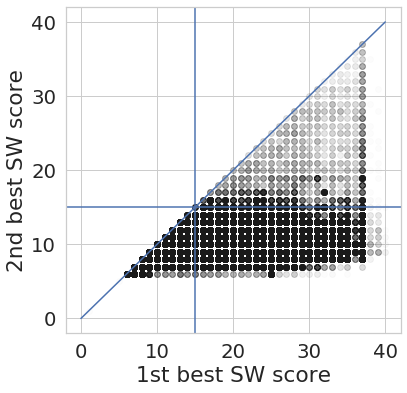

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

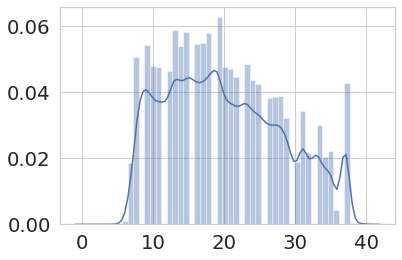

In [18]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [19]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [20]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [21]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [22]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/all_897cd225d1c3eef2d8da014b83aad9fb76f55a5f.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [23]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.replace(" ", "").split(",")

In [25]:
molbit_set_in_run = str(int(run_data.get("molbit_set")))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)
molbits_on_flowcell = list(np.unique(molbits_on_flowcell))

## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [26]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [27]:
len(accept_molbit)

352341

In [28]:
sum(accept_molbit)

248266

In [29]:
sum(accept_molbit) / len(accept_molbit)


0.7046185371557667

## Extract the best-aligned molbit, across ONLY the extant molbits

In [30]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [31]:
extant_sw = sw.loc[:, extant_sw_cols]

In [32]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [33]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [34]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [35]:
n_extant_is_best

247703

Percentage of well-aligned reads that belong to the true set

In [36]:
n_extant_is_best/len(sw_accepted)

0.9977322710318771

Read counts for each molbit

In [37]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('1', 2626),
 ('12', 7431),
 ('15', 7455),
 ('17', 2921),
 ('19', 9646),
 ('22', 2036),
 ('23', 823),
 ('25', 3087),
 ('28', 1161),
 ('29', 3868),
 ('32', 5275),
 ('35', 1943),
 ('37', 4468),
 ('38', 657),
 ('39', 3614),
 ('4', 909),
 ('40', 6304),
 ('43', 13173),
 ('45', 3320),
 ('46', 1279),
 ('5', 10990),
 ('50', 7168),
 ('51', 5925),
 ('52', 1330),
 ('54', 6308),
 ('57', 2711),
 ('62', 5816),
 ('63', 5265),
 ('65', 3532),
 ('66', 5019),
 ('67', 2559),
 ('68', 7318),
 ('69', 2750),
 ('7', 2891),
 ('70', 1578),
 ('73', 3517),
 ('75', 4893),
 ('76', 285),
 ('78', 714),
 ('79', 1097),
 ('80', 3781),
 ('81', 8236),
 ('83', 2106),
 ('85', 8916),
 ('86', 6782),
 ('87', 4064),
 ('88', 5896),
 ('89', 7922),
 ('9', 22422),
 ('90', 5572),
 ('92', 4942),
 ('93', 3965)]

In [38]:
print("\n".join([str(x) for x in c]))

2626
7431
7455
2921
9646
2036
823
3087
1161
3868
5275
1943
4468
657
3614
909
6304
13173
3320
1279
10990
7168
5925
1330
6308
2711
5816
5265
3532
5019
2559
7318
2750
2891
1578
3517
4893
285
714
1097
3781
8236
2106
8916
6782
4064
5896
7922
22422
5572
4942
3965


## Extract the best-aligned molbit, across ONLY the current run's molbits

In [39]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [40]:
extant_sw = sw.loc[:, extant_sw_cols]

In [41]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [42]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [43]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [44]:
n_extant_is_best

247749

Percentage of well-aligned reads that belong to the true set

In [45]:
n_extant_is_best/len(sw_accepted)

0.9979175561695923

Read counts for each molbit

In [46]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('1', 2626),
 ('12', 7429),
 ('15', 7451),
 ('17', 2921),
 ('19', 9641),
 ('22', 2035),
 ('23', 822),
 ('25', 3087),
 ('28', 1161),
 ('29', 3866),
 ('32', 5274),
 ('35', 1942),
 ('37', 4467),
 ('38', 657),
 ('39', 3613),
 ('4', 911),
 ('40', 6303),
 ('43', 13170),
 ('45', 3320),
 ('46', 1278),
 ('5', 10992),
 ('50', 7167),
 ('51', 5922),
 ('52', 1330),
 ('54', 6305),
 ('57', 2710),
 ('62', 5815),
 ('63', 5263),
 ('65', 3529),
 ('66', 5019),
 ('67', 2558),
 ('68', 7317),
 ('69', 2750),
 ('7', 2896),
 ('70', 1578),
 ('73', 3517),
 ('75', 4892),
 ('76', 284),
 ('78', 713),
 ('79', 1097),
 ('80', 3778),
 ('81', 8236),
 ('83', 2105),
 ('85', 8915),
 ('86', 6782),
 ('87', 4063),
 ('88', 5895),
 ('89', 7920),
 ('9', 22465),
 ('90', 5572),
 ('92', 4942),
 ('93', 3965)]

In [47]:
l = []
for i in range(0, 96, 16):
    l.extend(range(i, i+8))

In [48]:
", ".join([str(x) for x in l])

'0, 1, 2, 3, 4, 5, 6, 7, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 48, 49, 50, 51, 52, 53, 54, 55, 64, 65, 66, 67, 68, 69, 70, 71, 80, 81, 82, 83, 84, 85, 86, 87'

## Get counts for all molbits

In [49]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

0
2625
3
0
911
10988
0
2893
9
22411
0
2
7428
32
2
7444
2
2889
0
9641
1
0
2032
820
2
3084
2
1
1160
3866
1
0
5273
2
1
1940
47
4425
657
3613
6303
2
4
13165
0
3319
1256
11
0
152
7167
5921
1323
54
6302
22
1
2710
70
1
0
14
5785
5261
3
3528
5017
2552
7307
2739
1578
0
2
3514
5
4775
268
0
712
1066
3777
8236
43
2105
1
8908
6782
4030
5895
7919
5569
20
4896
3964
4
1


# Plot read counts

In [50]:
def plot_read_counts(labels, counts, labels_on_flowcell, labels_in_run,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per molbit"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Molbit ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         try:
#             label = int(label)
#         except:
#             pass
        
        if label in labels_in_run:
            g.containers[0].get_children()[j].set_facecolor("tab:red")
            font_kwargs = {"color": "tab:red", "weight": "bold"} 
        elif label in labels_on_flowcell:
            g.containers[0].get_children()[j].set_facecolor("tab:blue")
            font_kwargs = {"color": "k", "weight": "bold"}
        else:
            g.containers[0].get_children()[j].set_facecolor("k")
            font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count, ha="center", **font_kwargs)
        prev_text_height = text_height
        
    legend_elements = [Patch(facecolor='tab:blue', edgecolor='tab:blue',
                         label='median/typical molbits'),
                       Patch(facecolor='tab:red', edgecolor='tab:red',
                         label='highest/lowest molbits')]
    leg = ax.legend(handles=legend_elements)
    t1, t2 = leg.get_texts()
    t2._fontproperties = t1._fontproperties.copy()
#     t3._fontproperties = t1._fontproperties.copy()
    t1.set_weight('bold')
    t2.set_weight('bold')
    t2.set_color("tab:red")
    return ax

# Save labels

In [51]:
merged_sw_file


'/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/all_897cd225d1c3eef2d8da014b83aad9fb76f55a5f.tsv'

In [52]:
sw = pd.read_csv(merged_sw_file, sep="\t", index_col=0)
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit
sw["best_molbit_is_in_run"] = sw["best_molbit"].apply(lambda x: x in molbits_in_run)

labels_in_set = sw[np.logical_and(sw["accept_molbit"], sw["best_molbit_is_in_run"])]

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


In [53]:
sw_label_file = merged_sw_file.replace("all", "labels_for_molbits_in_set")
print(sw_label_file)

/path/to/data/MinION_sequencing_data_20191216/guppy_3.2.2_12_16_19_run_01_exec_20200107/sw/labels_for_molbits_in_set_897cd225d1c3eef2d8da014b83aad9fb76f55a5f.tsv


In [54]:
best_score = np.max(labels_in_set[[f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]], axis=1)
labels_in_set["best_score"] = best_score
labels_in_set = labels_in_set.loc[:, ["best_molbit", "best_score"]]
labels_in_set.columns = ["molbit", "sw_score"]

labels_in_set.to_csv(sw_label_file, sep="\t", index=True)

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Attempt to scale the counts

In [55]:
scaling_factor = [ 117.44079692,  296.08219178,   79.3902663 ,   63.8680128 ,
        301.24041812,  106.23305345,   50.35782934,   94.36710933,
        261.39458779,   23.42805573,  236.19903327,  215.71332122,
         72.68457433, 1674.82258065,  359.61558442,   92.43485034,
         55.15762106,  147.49710313,  161.68942521,   41.8235584 ,
         72.38555587,  124.39775226,  207.99019608,  599.71731449,
        410.15625   ,  146.23955432,   81.21546961,  151.60891089,
        265.91895803,   93.01442673,   59.58171206,   41.92334018,
         75.73638033,  100.18461538,  178.88385542,  176.9227836 ,
         35.15      ,   99.06164932,  435.15123095,  124.01737387,
        100.70515917,  113.01108647,  127.24327323,   34.53376496,
        113.68327138,   86.11075652,  317.00898411,  239.53629243,
         83.78780013,  276.0384821 ,   89.75808133,   32.18069662,
        250.71262136,  310.93798916,   76.84392204,  187.19391084,
        211.31315136,  165.0372093 ,   71.34651475,  403.21590909,
         35.59571978,  201.41721854,  126.01242971,   66.43719769,
       1425.49333333,  102.0477251 ,   39.45092251,   84.89571202,
         68.85702018,  148.00922935,  204.68155712,  104.81568627,
         66.45394046,  150.09968354,   32.68883529,   74.21318208,
        797.16806723,   93.0257416 ,  348.76102941,  372.37684004,
         95.12844828,   56.96902426,  143.82404692,  231.58237146,
        171.5491644 ,   65.69370442,   68.64634526,  119.36073553,
        128.91764706,   32.27093687,  114.79353994,  433.62242374,
         92.13242249,  293.19063545,  129.10751105,   86.49629995]